# Using YOLOv3 and OpenCV 4 to detect objects

I wanted to try to use OpenCV and YoloV3 in order to detect basics objects, this is what this notebook will be about.

*Thank you Joseph Redmon and Ali Farhadi for their incredible work on YOLO object detector* : **YOLOv3: An Incremental Improvement**, *Redmon, Joseph and Farhadi, Ali* ; arXiv, 2018.

This paper was my main inspiration for this notebook. 

In [33]:
# import useful libraries
import os
import numpy as np
import cv2
print('OpenCV version : ', cv2. __version__)
print(cv2.cuda.getCudaEnabledDeviceCount())

OpenCV version :  4.5.1
1


### Load YoloV3 models with pre-trained weights

In [2]:
# function to load our classes names
def read_classes(file):
    """ Read the classes files and extract the classes' names in it""" 
    classNames = []    
    with open(file, 'rt') as f:
        classNames = f.read().rstrip('\n').split('\n')
   
    return classNames

In [10]:
# test our function read_classes
img_file = './data/coco.names'
classNames = read_classes(img_file)
#classNames

### YoloV3 weights and cfg files

In this part we'll upload YoloV3 Weights and cfg files in order to input them into cv2.dnn.readNetFromDarknet() and build our forward propagation with OpenCV.

In [19]:
# load the model config and weights
modelConfig_path = './cfg/yolov3.cfg'
modelWeights_path = './models/yolov3-320.weights'

# read the model cfg and weights with the cv2 DNN module
neural_net = cv2.dnn.readNetFromDarknet(modelConfig_path, modelWeights_path)
# set the preferable Backend to GPU
neural_net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
neural_net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# confidence and non-max suppression threshold for this YoloV3 version
confidenceThreshold = 0.5
nmsThreshold = 0.2

## Function creation for object detection

In this part, we'll define the object detection function which allows us to get **the output of the three YOLO layers (82,94,106)** and select **the best bounding box** to put on the detected object, the layers' outputs are in the format :
- The confidence probability (if there is an object or not in the frame)
- (x,y) coordinates of the center of the object
- (height, width) of the frame
- All the scores of the detected object (if there is an object detected, which one is it?)

We know that the first 5 elements of the results ouputs are not the "scores", **i.e.** : *the 80 classes probabilities of what kind of object is detected*. That's why we'll start to store our outputs layers' values in different lists, the first one will stock all the **scores** from the fifth element to the last element (85th), then we'll collect the first 5 elements. 

For the 5th to 85th elements corresponding to *the objects scores*, we'll take the maximum value which will represent the **highest probability** about what's the object's class.

#### Object detection function

Based on what we've detailed above, we'll write an object detection function.

In [20]:
def object_detection(outputs, input_frame):
    """ This function will allow us to draw bounding boxes on detected objects in frames (images) """
    # first we'll collect the height, width and channel of the input frame (3 if the image is RGB, 1 if it's grayscale)
    height, width, channel = input_frame.shape
    
    # we'll create category lists to store the layers' output values 
    bounding_boxes = []
    class_objects = []
    confidence_probs = []
    
    # Knowing that there are 3 YOLO layers, we'll browsing them and their outputs using this :
    for result in outputs:        
        for values in result:
            
            scores = values[5:] # we know that the class probabilities are from the 5th values
            indices_object = np.argmax(scores) # get the indice of the max score
            confidence_probability = scores[indices_object] # store the maximum value of the indice found
            
            # in order to have a proper detection, we'll eliminate the weakest probability detection by imposing a threshold
            if confidence_probability > confidenceThreshold:   
                
                # get the pixel values corresponding to the scaling of the bounding box coordinates to the initial frame
                box_detected = values[0:4] * np.array([width, height, width, height])                                 
                # get the top left corner coordinates by extracting values from box_detected and perform calculations
                x, y, w, h = box_detected
                # we're converting the coordinates to int because OpenCV doesn't allow floats for bounding boxes
                x = int(x - (w/2))
                y = int(y - (h/2))
                
                # adding the good detected boxe in the bounding boxes list created
                bounding_boxes.append([x,y,w,h])                
                # adding the detected objects indices in the class objects list 
                class_objects.append(indices_object)                
                # adding the max value of the object score (confidence) in the confidences_probs list
                confidence_probs.append(float(confidence_probability))    
                    
    return bounding_boxes, class_objects, confidence_probs

#### Non-max suppresion function

When we're doing object detection with YoloV3, the algorithm outputs several bounding boxes. In order to keep the best bounding box we'll need to perform a maximizimation technique called **non-max suppression**, this method will allow us to keep the bounding box with the highest probability and eliminate the others.

In [21]:
def nms_bbox(bounding_boxes, confidence_probs, confidenceThreshold, nmsThreshold):
    """This function performs non-max suppression on all the bounding boxes detected and keeps the best one"""    
    #Using OpenCV DNN non-max supression to get the best bounding box of the detected object (retrieve the indices)
    indices_bbox = cv2.dnn.NMSBoxes(bounding_boxes, confidence_probs, confidenceThreshold, nmsThreshold)        
    print('Number of objects detected : ', len(indices_bbox), '\n')
    
    return indices_bbox

#### Drawing box function

Now, we have only one bounding box left (the best one) and we'll just need to draw the corresponding box.

In [22]:
def box_drawing(input_frame, indices, bounding_boxes, class_objects, confidence_probs, classNames, color=(0,255,255), thickness=2):
    """ Drawing the detected objects boxes """
    # once we have the indices, we'll extract the values of x,y,w,h of the best bounding boxes and stores it.
    for i in indices:
        i = i[0]
        final_box = bounding_boxes[i]
    # we'll retrieve the bounding boxes values (coordinates) now and use them to draw our boxes.
        x, y, w, h = final_box[0], final_box[1], final_box[2], final_box[3]
        x, y, w, h = int(x), int(y), int(w), int(h)        
        print('Bounding box coordinates in the frame : ', 'x : ', x,'|| y : ',y,'|| w : ',w,'|| h :',h , '\n')
    
        cv2.rectangle(input_frame, (x,y), (x+w,y+h),  color, 2)
        cv2.putText(input_frame, f'{classNames[class_objects[i]].upper()} {int(confidence_probs[i]*100)}%',
                        (x, y-10), cv2.FONT_HERSHEY_DUPLEX, 0.6,  color, 2)
    

####  Blob function 

OpenCV uses blob techniques to extract features from an image and allows detection. In order to be able to do forward propagation on our images or videos, we'll need to convert our images to **OpenCV blob's format**.

In [23]:
def convert_to_blob(input_frame, network, height=320, width=320):
    """ This function allow us to convert a frame/image into blob format for OpenCV DNN"""    
    blob = cv2.dnn.blobFromImage(input_frame, 1/255, (height,width), [0,0,0], 1, crop=False)
    network.setInput(blob)
    # get the YOLO output layers numbers (names), these layers will be useful for the detection part
    # the layer's name : yolo_82, yolo_94, yolo_106
    yoloLayers = network.getLayerNames()
    outputLayers = [(yoloLayers[i[0]-1]) for i in network.getUnconnectedOutLayers()]
    # Doing forward propagation with OpenCV
    outputs = network.forward(outputLayers)
    
    return outputs

### Test on image files

These blocks will run object detection on images in our **images** folder.

In [24]:
# method to load our image from directory
import os 

def load_image(image):    
    """ Return the video by inputing the title of the video """ 

    # get the video path and load the video
    image_path = os.path.join('images', image)
    
    return image_path

In [31]:
network = neural_net
height, width = 320,320

img = cv2.imread(load_image('test.jpg'))

# using convert_to_blob function : 
outputs = convert_to_blob(img, network)    
# apply object detection on the video file
bounding_boxes, class_objects, confidence_probs = object_detection(outputs, img)   
# perform non-max suppression
indices = nms_bbox(bounding_boxes, confidence_probs, confidenceThreshold, nmsThreshold)
# draw the boxes
box_drawing(img, indices, bounding_boxes, class_objects, confidence_probs, classNames, color=(0,255,255), thickness=2)

# to save the detected image
img_save = cv2.imwrite('./results/imgs/detect_img3.jpg', img)

cv2.imshow('Object detection in images', img)
cv2.waitKey()
cv2.destroyAllWindows()

Number of objects detected :  12 

Bounding box coordinates in the frame :  x :  370 || y :  318 || w :  386 || h : 300 

Bounding box coordinates in the frame :  x :  137 || y :  305 || w :  199 || h : 136 

Bounding box coordinates in the frame :  x :  949 || y :  323 || w :  337 || h : 347 

Bounding box coordinates in the frame :  x :  926 || y :  286 || w :  128 || h : 95 

Bounding box coordinates in the frame :  x :  755 || y :  277 || w :  170 || h : 127 

Bounding box coordinates in the frame :  x :  709 || y :  277 || w :  75 || h : 71 

Bounding box coordinates in the frame :  x :  316 || y :  299 || w :  56 || h : 61 

Bounding box coordinates in the frame :  x :  669 || y :  282 || w :  43 || h : 32 

Bounding box coordinates in the frame :  x :  576 || y :  250 || w :  71 || h : 51 

Bounding box coordinates in the frame :  x :  385 || y :  298 || w :  37 || h : 28 

Bounding box coordinates in the frame :  x :  966 || y :  214 || w :  15 || h : 17 

Bounding box coordina

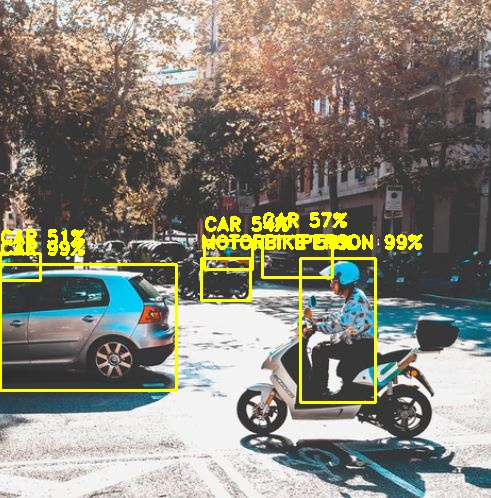

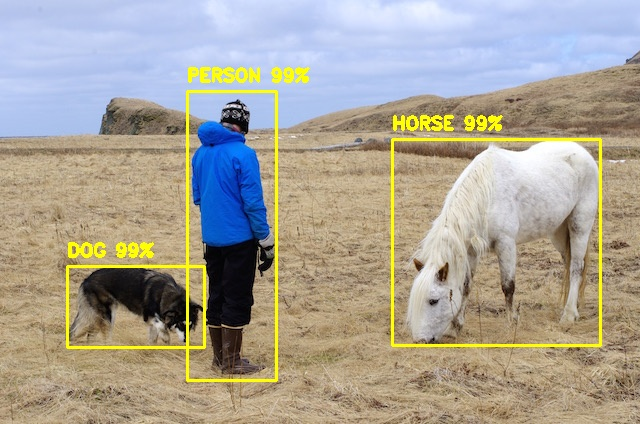

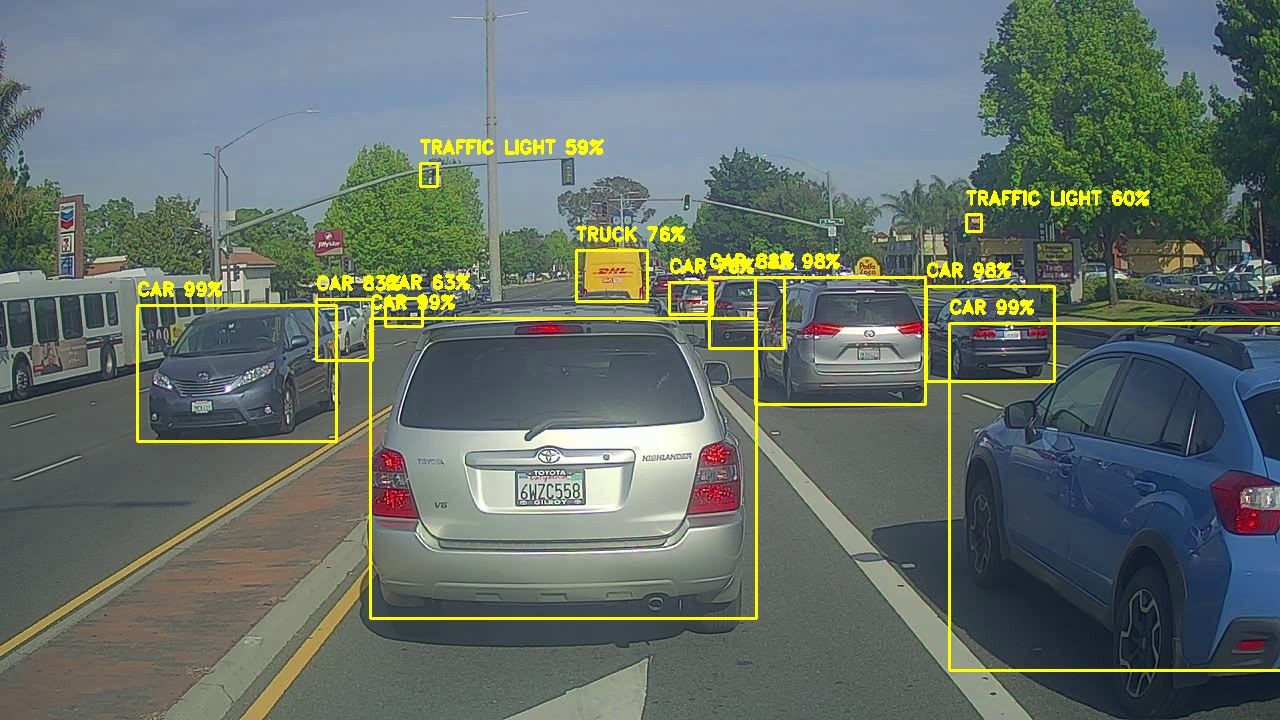

In [32]:
from IPython.display import display, Image

# display our saved imgs
display(Image(filename='./results/imgs/detect_img2.jpg'))
display(Image(filename='./results/imgs/detect_img.jpg'))
display(Image(filename='./results/imgs/detect_img3.jpg'))